# HW07 - Кластеризация и внутренние метрики качества

Домашнее задание по кластеризации с использованием KMeans, DBSCAN и Agglomerative Clustering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

plt.style.use('default')
np.random.seed(42)

os.makedirs('artifacts/figures', exist_ok=True)
os.makedirs('artifacts/labels', exist_ok=True)

## 1. Загрузка данных

In [2]:
# Загрузка всех датасетов
df1 = pd.read_csv('data/S07-hw-dataset-01.csv')
df2 = pd.read_csv('data/S07-hw-dataset-02.csv')
df3 = pd.read_csv('data/S07-hw-dataset-03.csv')

print("Dataset 01:", df1.shape)
print("Dataset 02:", df2.shape)
print("Dataset 03:", df3.shape)

Dataset 01: (12000, 9)
Dataset 02: (8000, 4)
Dataset 03: (15000, 5)


In [3]:
# Анализ Dataset 01
print("=== Dataset 01 ===")
print(df1.head())
print(df1.info())
print(df1.describe())
print("Пропуски:", df1.isnull().sum().sum())

=== Dataset 01 ===
   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null

In [4]:
# Анализ Dataset 02
print("=== Dataset 02 ===")
print(df2.head())
print(df2.info())
print(df2.describe())
print("Пропуски:", df2.isnull().sum().sum())

=== Dataset 02 ===
   sample_id        x1        x2    z_noise
0          0  0.098849 -1.846034  21.288122
1          1 -1.024516  1.829616   6.072952
2          2 -1.094178 -0.158545 -18.938342
3          3 -1.612808 -1.565844 -11.629462
4          4  1.659901 -2.133292   1.895472
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB
None
        sample_id           x1           x2      z_noise
count  8000.00000  8000.000000  8000.000000  8000.000000
mean   3999.50000     0.478867     0.241112     0.110454
std    2309.54541     0.955138     0.663195     8.097716
min       0.00000    -2.487352    -2.499237   -34.056074
25%    1999.75000    -0.11651

In [5]:
# Анализ Dataset 03
print("=== Dataset 03 ===")
print(df3.head())
print(df3.info())
print(df3.describe())
print("Пропуски:", df3.isnull().sum().sum())

=== Dataset 03 ===
   sample_id        x1        x2    f_corr   f_noise
0          0 -2.710470  4.997107 -1.015703  0.718508
1          1  8.730238 -8.787416  3.953063 -1.105349
2          2 -1.079600 -2.558708  0.976628 -3.605776
3          3  6.854042  1.560181  1.760614 -1.230946
4          4  9.963812 -8.869921  2.966583  0.915899
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB
None
          sample_id            x1            x2        f_corr       f_noise
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000
mean    7499.500000      1.246296      1.033764      0.212776     

## 2. Препроцессинг

In [6]:
# Подготовка данных
sample_ids_1 = df1['sample_id']
sample_ids_2 = df2['sample_id']
sample_ids_3 = df3['sample_id']

X1 = df1.drop('sample_id', axis=1)
X2 = df2.drop('sample_id', axis=1)
X3 = df3.drop('sample_id', axis=1)

# Масштабирование
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()

X1_scaled = scaler1.fit_transform(X1)
X2_scaled = scaler2.fit_transform(X2)
X3_scaled = scaler3.fit_transform(X3)

print("Препроцессинг завершен")

Препроцессинг завершен


## 3. Функции для анализа

In [7]:
def evaluate_clustering(X, labels, algorithm_name):
    """Вычисляет метрики качества кластеризации"""
    if algorithm_name == 'DBSCAN':
        noise_ratio = (labels == -1).sum() / len(labels)
        
        if len(set(labels)) <= 1 or (len(set(labels)) == 2 and -1 in labels):
            return {
                'silhouette': None,
                'davies_bouldin': None,
                'calinski_harabasz': None,
                'noise_ratio': noise_ratio
            }
        
        non_noise_mask = labels != -1
        if non_noise_mask.sum() < 2:
            return {
                'silhouette': None,
                'davies_bouldin': None,
                'calinski_harabasz': None,
                'noise_ratio': noise_ratio
            }
        
        X_non_noise = X[non_noise_mask]
        labels_non_noise = labels[non_noise_mask]
        
        if len(set(labels_non_noise)) < 2:
            return {
                'silhouette': None,
                'davies_bouldin': None,
                'calinski_harabasz': None,
                'noise_ratio': noise_ratio
            }
        
        silhouette = silhouette_score(X_non_noise, labels_non_noise)
        davies_bouldin = davies_bouldin_score(X_non_noise, labels_non_noise)
        calinski_harabasz = calinski_harabasz_score(X_non_noise, labels_non_noise)
        
        return {
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'calinski_harabasz': calinski_harabasz,
            'noise_ratio': noise_ratio
        }
    else:
        if len(set(labels)) < 2:
            return {
                'silhouette': None,
                'davies_bouldin': None,
                'calinski_harabasz': None
            }
        
        silhouette = silhouette_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels)
        calinski_harabasz = calinski_harabasz_score(X, labels)
        
        return {
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'calinski_harabasz': calinski_harabasz
        }

## 4. Анализ Dataset 01

=== АНАЛИЗ DATASET 01 ===


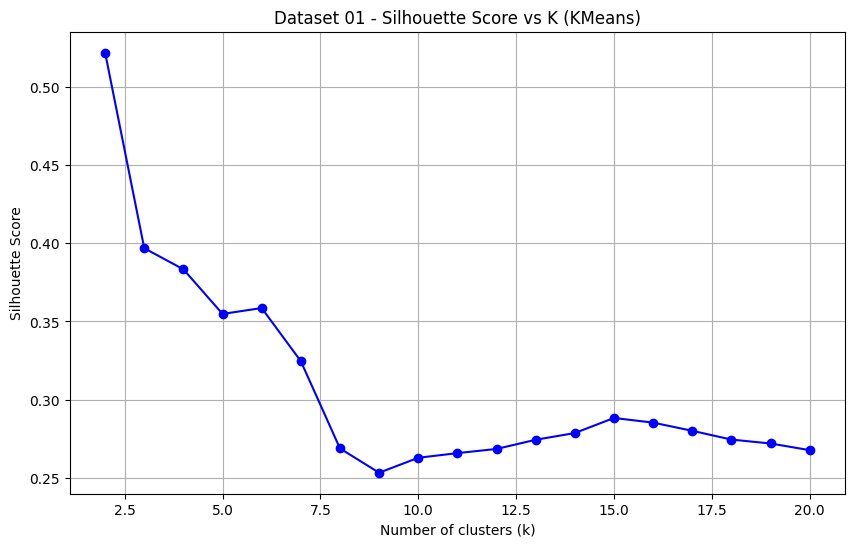

Лучшее k: 2


In [8]:
print("=== АНАЛИЗ DATASET 01 ===")

# KMeans подбор k
k_range = range(2, 21)
silhouette_scores_1 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X1_scaled)
    metrics = evaluate_clustering(X1_scaled, labels, 'KMeans')
    silhouette_scores_1.append(metrics['silhouette'])

# График метрик
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores_1, 'bo-')
plt.title('Dataset 01 - Silhouette Score vs K (KMeans)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.savefig('artifacts/figures/dataset01_kmeans_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

best_k_1 = k_range[np.argmax(silhouette_scores_1)]
print(f"Лучшее k: {best_k_1}")

In [9]:
# Лучший KMeans для Dataset 01
kmeans_1 = KMeans(n_clusters=best_k_1, random_state=42, n_init=10)
kmeans_labels_1 = kmeans_1.fit_predict(X1_scaled)
kmeans_metrics_1 = evaluate_clustering(X1_scaled, kmeans_labels_1, 'KMeans')

print(f"KMeans результаты:")
print(f"Silhouette: {kmeans_metrics_1['silhouette']:.3f}")
print(f"Davies-Bouldin: {kmeans_metrics_1['davies_bouldin']:.3f}")
print(f"Calinski-Harabasz: {kmeans_metrics_1['calinski_harabasz']:.3f}")

KMeans результаты:
Silhouette: 0.522
Davies-Bouldin: 0.685
Calinski-Harabasz: 11786.955


In [10]:
# DBSCAN для Dataset 01
eps_range = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
min_samples_range = [3, 5, 10]

best_dbscan_metrics_1 = {'silhouette': -1}
best_dbscan_params_1 = {}
best_dbscan_labels_1 = None

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X1_scaled)
        metrics = evaluate_clustering(X1_scaled, labels, 'DBSCAN')
        
        if metrics['silhouette'] is not None and metrics['silhouette'] > best_dbscan_metrics_1['silhouette']:
            best_dbscan_metrics_1 = metrics
            best_dbscan_params_1 = {'eps': eps, 'min_samples': min_samples}
            best_dbscan_labels_1 = labels

print(f"DBSCAN лучшие параметры: {best_dbscan_params_1}")
print(f"Silhouette: {best_dbscan_metrics_1['silhouette']:.3f}")
if 'noise_ratio' in best_dbscan_metrics_1:
    print(f"Доля шума: {best_dbscan_metrics_1['noise_ratio']:.3f}")

DBSCAN лучшие параметры: {'eps': 2.0, 'min_samples': 3}
Silhouette: 0.522
Доля шума: 0.000


Лучший алгоритм для Dataset 01: DBSCAN


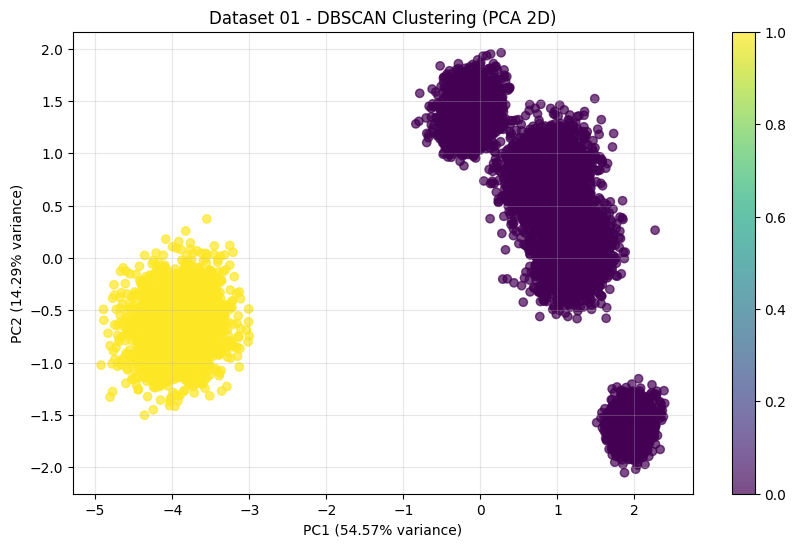

In [11]:
# Выбор лучшего для Dataset 01
if kmeans_metrics_1['silhouette'] > best_dbscan_metrics_1['silhouette']:
    best_algorithm_1 = 'KMeans'
    best_labels_1 = kmeans_labels_1
    best_metrics_1 = kmeans_metrics_1
    best_params_1 = {'algorithm': 'KMeans', 'n_clusters': best_k_1}
else:
    best_algorithm_1 = 'DBSCAN'
    best_labels_1 = best_dbscan_labels_1
    best_metrics_1 = best_dbscan_metrics_1
    best_params_1 = {'algorithm': 'DBSCAN', **best_dbscan_params_1}

print(f"Лучший алгоритм для Dataset 01: {best_algorithm_1}")

# PCA визуализация
pca_1 = PCA(n_components=2, random_state=42)
X1_pca = pca_1.fit_transform(X1_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X1_pca[:, 0], X1_pca[:, 1], c=best_labels_1, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title(f'Dataset 01 - {best_algorithm_1} Clustering (PCA 2D)')
plt.xlabel(f'PC1 ({pca_1.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_1.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, alpha=0.3)
plt.savefig('artifacts/figures/dataset01_best_clustering_pca.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Анализ Dataset 02

=== АНАЛИЗ DATASET 02 ===


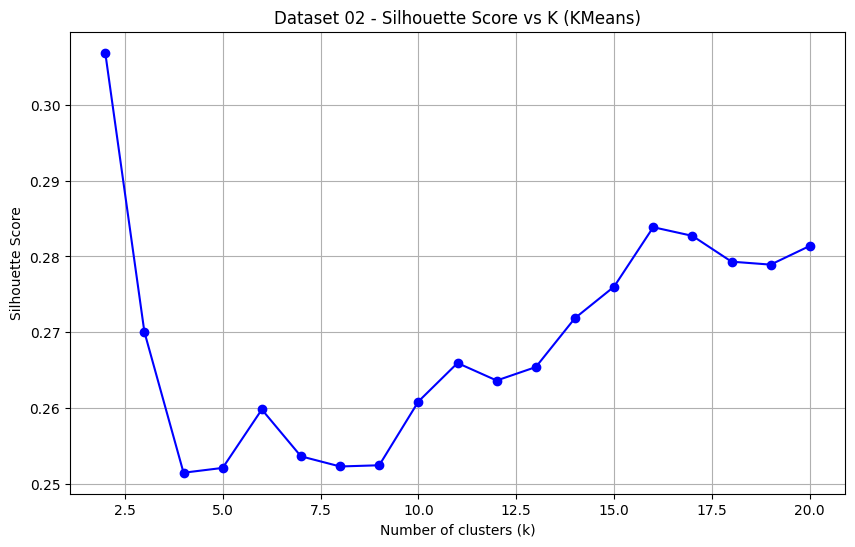

Лучшее k: 2


In [12]:
print("=== АНАЛИЗ DATASET 02 ===")

# KMeans подбор k
silhouette_scores_2 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X2_scaled)
    metrics = evaluate_clustering(X2_scaled, labels, 'KMeans')
    silhouette_scores_2.append(metrics['silhouette'])

# График метрик
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores_2, 'bo-')
plt.title('Dataset 02 - Silhouette Score vs K (KMeans)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.savefig('artifacts/figures/dataset02_kmeans_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

best_k_2 = k_range[np.argmax(silhouette_scores_2)]
print(f"Лучшее k: {best_k_2}")

In [13]:
# Лучший KMeans для Dataset 02
kmeans_2 = KMeans(n_clusters=best_k_2, random_state=42, n_init=10)
kmeans_labels_2 = kmeans_2.fit_predict(X2_scaled)
kmeans_metrics_2 = evaluate_clustering(X2_scaled, kmeans_labels_2, 'KMeans')

print(f"KMeans результаты:")
print(f"Silhouette: {kmeans_metrics_2['silhouette']:.3f}")
print(f"Davies-Bouldin: {kmeans_metrics_2['davies_bouldin']:.3f}")
print(f"Calinski-Harabasz: {kmeans_metrics_2['calinski_harabasz']:.3f}")

KMeans результаты:
Silhouette: 0.307
Davies-Bouldin: 1.323
Calinski-Harabasz: 3573.393


In [14]:
# DBSCAN для Dataset 02
best_dbscan_metrics_2 = {'silhouette': -1}
best_dbscan_params_2 = {}
best_dbscan_labels_2 = None

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X2_scaled)
        metrics = evaluate_clustering(X2_scaled, labels, 'DBSCAN')
        
        if metrics['silhouette'] is not None and metrics['silhouette'] > best_dbscan_metrics_2['silhouette']:
            best_dbscan_metrics_2 = metrics
            best_dbscan_params_2 = {'eps': eps, 'min_samples': min_samples}
            best_dbscan_labels_2 = labels

print(f"DBSCAN лучшие параметры: {best_dbscan_params_2}")
print(f"Silhouette: {best_dbscan_metrics_2['silhouette']:.3f}")
if 'noise_ratio' in best_dbscan_metrics_2:
    print(f"Доля шума: {best_dbscan_metrics_2['noise_ratio']:.3f}")

DBSCAN лучшие параметры: {'eps': 0.7, 'min_samples': 3}
Silhouette: 0.346
Доля шума: 0.007


Лучший алгоритм для Dataset 02: DBSCAN


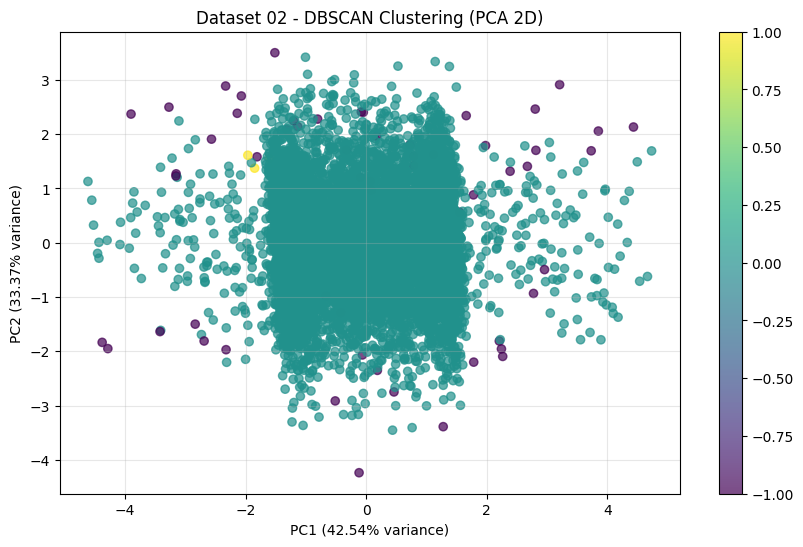

In [15]:
# Выбор лучшего для Dataset 02
if kmeans_metrics_2['silhouette'] > best_dbscan_metrics_2['silhouette']:
    best_algorithm_2 = 'KMeans'
    best_labels_2 = kmeans_labels_2
    best_metrics_2 = kmeans_metrics_2
    best_params_2 = {'algorithm': 'KMeans', 'n_clusters': best_k_2}
else:
    best_algorithm_2 = 'DBSCAN'
    best_labels_2 = best_dbscan_labels_2
    best_metrics_2 = best_dbscan_metrics_2
    best_params_2 = {'algorithm': 'DBSCAN', **best_dbscan_params_2}

print(f"Лучший алгоритм для Dataset 02: {best_algorithm_2}")

# PCA визуализация
pca_2 = PCA(n_components=2, random_state=42)
X2_pca = pca_2.fit_transform(X2_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X2_pca[:, 0], X2_pca[:, 1], c=best_labels_2, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title(f'Dataset 02 - {best_algorithm_2} Clustering (PCA 2D)')
plt.xlabel(f'PC1 ({pca_2.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_2.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, alpha=0.3)
plt.savefig('artifacts/figures/dataset02_best_clustering_pca.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Анализ Dataset 03

=== АНАЛИЗ DATASET 03 ===


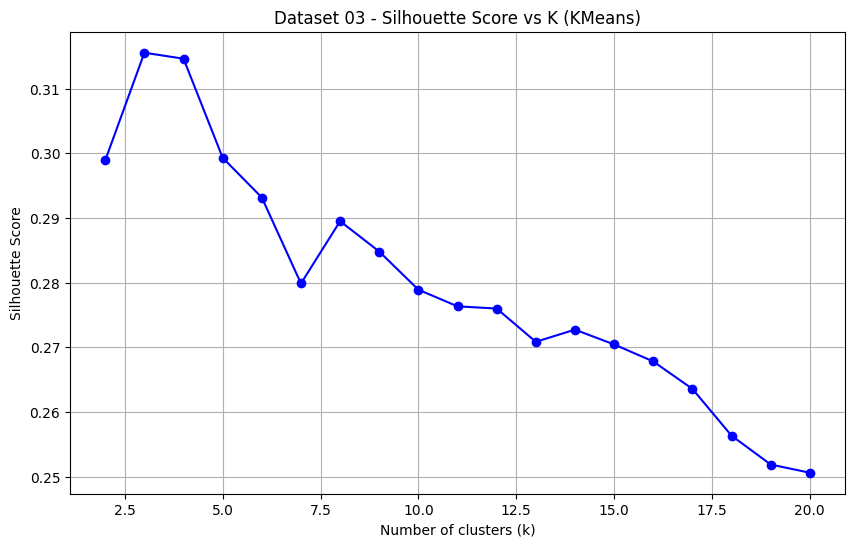

Лучшее k: 3


In [16]:
print("=== АНАЛИЗ DATASET 03 ===")

# KMeans подбор k
silhouette_scores_3 = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X3_scaled)
    metrics = evaluate_clustering(X3_scaled, labels, 'KMeans')
    silhouette_scores_3.append(metrics['silhouette'])

# График метрик
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores_3, 'bo-')
plt.title('Dataset 03 - Silhouette Score vs K (KMeans)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.savefig('artifacts/figures/dataset03_kmeans_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

best_k_3 = k_range[np.argmax(silhouette_scores_3)]
print(f"Лучшее k: {best_k_3}")

In [17]:
# Лучший KMeans для Dataset 03
kmeans_3 = KMeans(n_clusters=best_k_3, random_state=42, n_init=10)
kmeans_labels_3 = kmeans_3.fit_predict(X3_scaled)
kmeans_metrics_3 = evaluate_clustering(X3_scaled, kmeans_labels_3, 'KMeans')

print(f"KMeans результаты:")
print(f"Silhouette: {kmeans_metrics_3['silhouette']:.3f}")
print(f"Davies-Bouldin: {kmeans_metrics_3['davies_bouldin']:.3f}")
print(f"Calinski-Harabasz: {kmeans_metrics_3['calinski_harabasz']:.3f}")

KMeans результаты:
Silhouette: 0.316
Davies-Bouldin: 1.158
Calinski-Harabasz: 6957.163


In [18]:
# AgglomerativeClustering для Dataset 03 (вместо DBSCAN)
linkage_types = ['ward', 'complete', 'average']
k_agg_range = range(2, 11)

best_agg_metrics_3 = {'silhouette': -1}
best_agg_params_3 = {}
best_agg_labels_3 = None

for linkage in linkage_types:
    for k in k_agg_range:
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(X3_scaled)
        metrics = evaluate_clustering(X3_scaled, labels, 'AgglomerativeClustering')
        
        if metrics['silhouette'] is not None and metrics['silhouette'] > best_agg_metrics_3['silhouette']:
            best_agg_metrics_3 = metrics
            best_agg_params_3 = {'n_clusters': k, 'linkage': linkage}
            best_agg_labels_3 = labels

print(f"AgglomerativeClustering лучшие параметры: {best_agg_params_3}")
print(f"Silhouette: {best_agg_metrics_3['silhouette']:.3f}")
print(f"Davies-Bouldin: {best_agg_metrics_3['davies_bouldin']:.3f}")
print(f"Calinski-Harabasz: {best_agg_metrics_3['calinski_harabasz']:.3f}")

AgglomerativeClustering лучшие параметры: {'n_clusters': 2, 'linkage': 'average'}
Silhouette: 0.425
Davies-Bouldin: 0.814
Calinski-Harabasz: 8.943


Лучший алгоритм для Dataset 03: AgglomerativeClustering


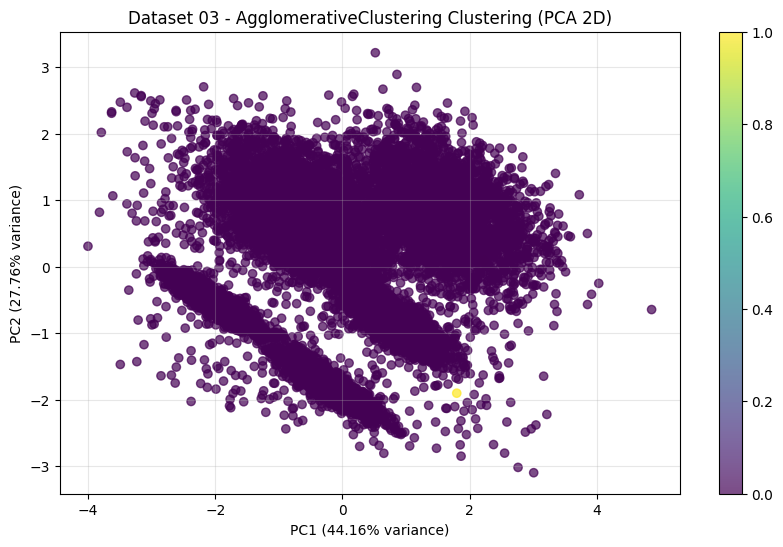

In [19]:
# Выбор лучшего для Dataset 03
if kmeans_metrics_3['silhouette'] > best_agg_metrics_3['silhouette']:
    best_algorithm_3 = 'KMeans'
    best_labels_3 = kmeans_labels_3
    best_metrics_3 = kmeans_metrics_3
    best_params_3 = {'algorithm': 'KMeans', 'n_clusters': best_k_3}
else:
    best_algorithm_3 = 'AgglomerativeClustering'
    best_labels_3 = best_agg_labels_3
    best_metrics_3 = best_agg_metrics_3
    best_params_3 = {'algorithm': 'AgglomerativeClustering', **best_agg_params_3}

print(f"Лучший алгоритм для Dataset 03: {best_algorithm_3}")

# PCA визуализация
pca_3 = PCA(n_components=2, random_state=42)
X3_pca = pca_3.fit_transform(X3_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X3_pca[:, 0], X3_pca[:, 1], c=best_labels_3, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title(f'Dataset 03 - {best_algorithm_3} Clustering (PCA 2D)')
plt.xlabel(f'PC1 ({pca_3.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_3.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, alpha=0.3)
plt.savefig('artifacts/figures/dataset03_best_clustering_pca.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Проверка устойчивости

In [20]:
print("=== ПРОВЕРКА УСТОЙЧИВОСТИ ===")

# 5 запусков KMeans с разными random_state
random_states = [42, 123, 456, 789, 999]
all_labels = []

for rs in random_states:
    kmeans = KMeans(n_clusters=best_k_1, random_state=rs, n_init=10)
    labels = kmeans.fit_predict(X1_scaled)
    all_labels.append(labels)
    metrics = evaluate_clustering(X1_scaled, labels, 'KMeans')
    print(f"Random state {rs}: Silhouette = {metrics['silhouette']:.3f}")

# ARI между запусками
ari_scores = []
for i in range(len(all_labels)):
    for j in range(i+1, len(all_labels)):
        ari = adjusted_rand_score(all_labels[i], all_labels[j])
        ari_scores.append(ari)

mean_ari = np.mean(ari_scores)
print(f"Средний ARI: {mean_ari:.3f}")

if mean_ari > 0.8:
    print("Кластеризация УСТОЙЧИВА")
elif mean_ari > 0.6:
    print("Кластеризация УМЕРЕННО УСТОЙЧИВА")
else:
    print("Кластеризация НЕУСТОЙЧИВА")

=== ПРОВЕРКА УСТОЙЧИВОСТИ ===
Random state 42: Silhouette = 0.522
Random state 123: Silhouette = 0.522
Random state 456: Silhouette = 0.522
Random state 789: Silhouette = 0.522
Random state 999: Silhouette = 0.522
Средний ARI: 1.000
Кластеризация УСТОЙЧИВА


## 8. Сохранение результатов

In [21]:
# Сохранение меток для всех датасетов
labels_df_1 = pd.DataFrame({
    'sample_id': sample_ids_1,
    'cluster_label': best_labels_1
})
labels_df_1.to_csv('artifacts/labels/labels_hw07_ds1.csv', index=False)

labels_df_2 = pd.DataFrame({
    'sample_id': sample_ids_2,
    'cluster_label': best_labels_2
})
labels_df_2.to_csv('artifacts/labels/labels_hw07_ds2.csv', index=False)

labels_df_3 = pd.DataFrame({
    'sample_id': sample_ids_3,
    'cluster_label': best_labels_3
})
labels_df_3.to_csv('artifacts/labels/labels_hw07_ds3.csv', index=False)

# Сохранение метрик для всех датасетов
results = {
    'dataset_01': {
        'best_algorithm': best_algorithm_1,
        'best_params': best_params_1,
        'metrics': best_metrics_1
    },
    'dataset_02': {
        'best_algorithm': best_algorithm_2,
        'best_params': best_params_2,
        'metrics': best_metrics_2
    },
    'dataset_03': {
        'best_algorithm': best_algorithm_3,
        'best_params': best_params_3,
        'metrics': best_metrics_3
    }
}

with open('artifacts/metrics_summary.json', 'w') as f:
    json.dump(results, f, indent=2)

with open('artifacts/best_configs.json', 'w') as f:
    json.dump({
        'dataset_01': best_params_1,
        'dataset_02': best_params_2,
        'dataset_03': best_params_3,
        'selection_criterion': 'silhouette_score'
    }, f, indent=2)

print("Все результаты сохранены!")
print("\n=== ИТОГОВЫЕ РЕЗУЛЬТАТЫ ===")
print(f"Dataset 01: {best_algorithm_1} - Silhouette: {best_metrics_1['silhouette']:.3f}")
print(f"Dataset 02: {best_algorithm_2} - Silhouette: {best_metrics_2['silhouette']:.3f}")
print(f"Dataset 03: {best_algorithm_3} - Silhouette: {best_metrics_3['silhouette']:.3f}")

print("\nСохраненные файлы:")
print("- artifacts/metrics_summary.json")
print("- artifacts/best_configs.json")
print("- artifacts/labels/labels_hw07_ds1.csv")
print("- artifacts/labels/labels_hw07_ds2.csv")
print("- artifacts/labels/labels_hw07_ds3.csv")
print("- artifacts/figures/dataset01_kmeans_metrics.png")
print("- artifacts/figures/dataset01_best_clustering_pca.png")
print("- artifacts/figures/dataset02_kmeans_metrics.png")
print("- artifacts/figures/dataset02_best_clustering_pca.png")
print("- artifacts/figures/dataset03_kmeans_metrics.png")
print("- artifacts/figures/dataset03_best_clustering_pca.png")

Все результаты сохранены!

=== ИТОГОВЫЕ РЕЗУЛЬТАТЫ ===
Dataset 01: DBSCAN - Silhouette: 0.522
Dataset 02: DBSCAN - Silhouette: 0.346
Dataset 03: AgglomerativeClustering - Silhouette: 0.425

Сохраненные файлы:
- artifacts/metrics_summary.json
- artifacts/best_configs.json
- artifacts/labels/labels_hw07_ds1.csv
- artifacts/labels/labels_hw07_ds2.csv
- artifacts/labels/labels_hw07_ds3.csv
- artifacts/figures/dataset01_kmeans_metrics.png
- artifacts/figures/dataset01_best_clustering_pca.png
- artifacts/figures/dataset02_kmeans_metrics.png
- artifacts/figures/dataset02_best_clustering_pca.png
- artifacts/figures/dataset03_kmeans_metrics.png
- artifacts/figures/dataset03_best_clustering_pca.png
